In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Data Science/bank_amazon

%pip install seaborn
%pip install matplotlib

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Data Science/bank_amazon
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


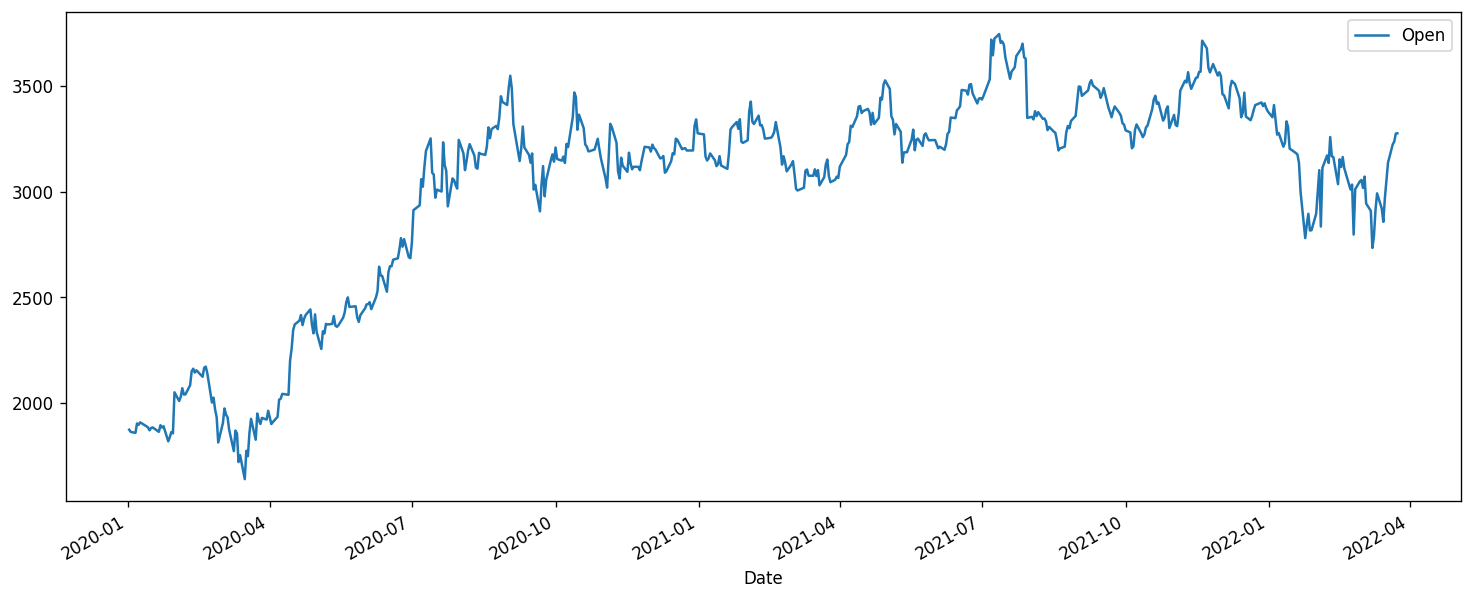

In [ ]:
#Import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=Warning)

#Lettura file
df = pd.read_csv('./AMZN_reduced.csv')
df = df[['Date','Open']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.plot()
#df.Open.plot()

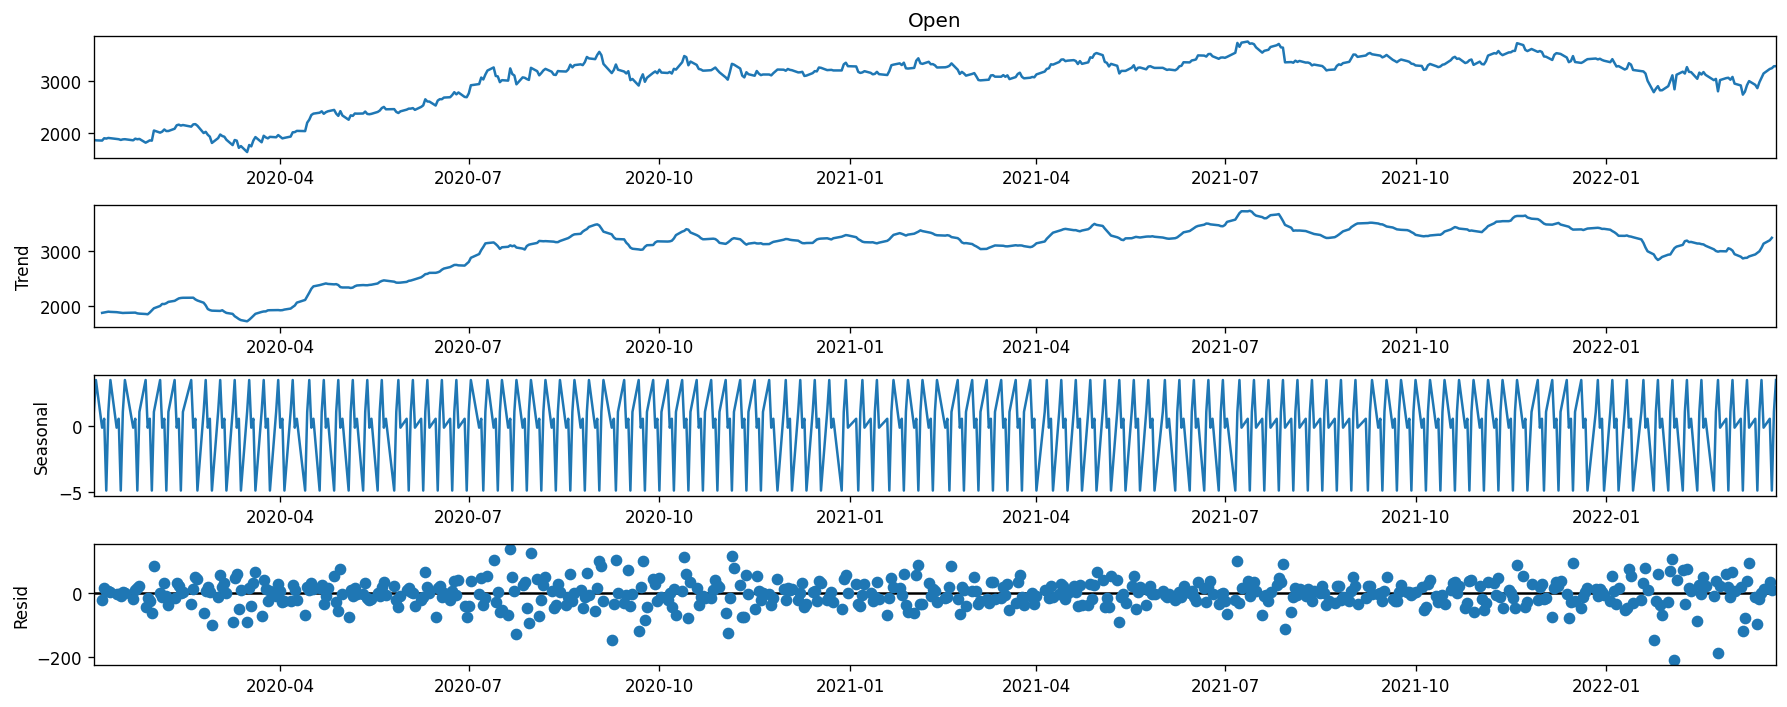

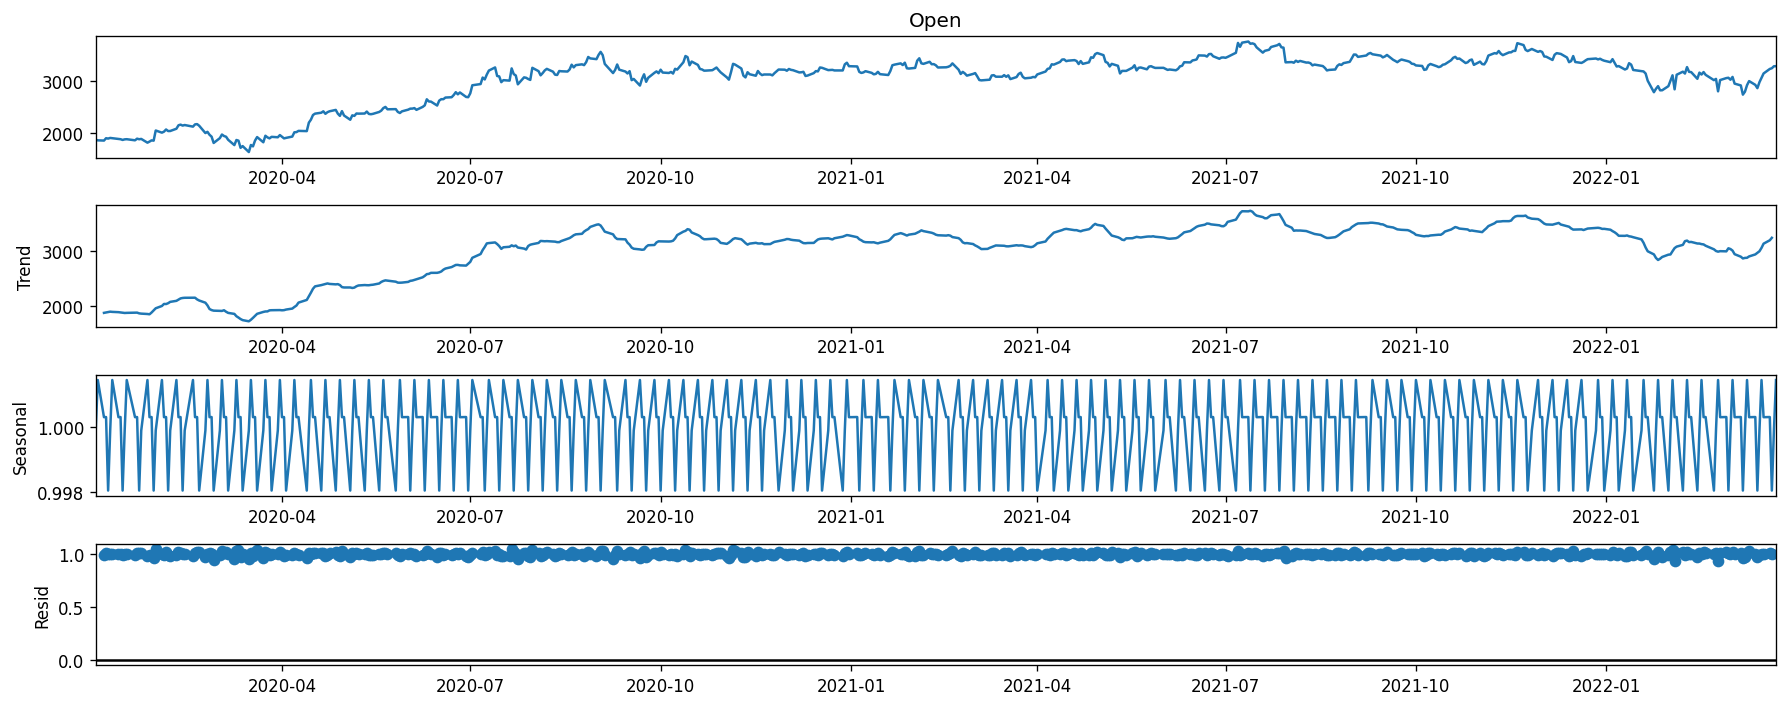

In [ ]:
#Decomposizione
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':120})
aresult = seasonal_decompose(df.Open, model='additive', freq=5)
aresult.plot()
plt.show()

mresult = seasonal_decompose(df.Open, model='multiplcative', freq=5)
mresult.plot()
plt.show()

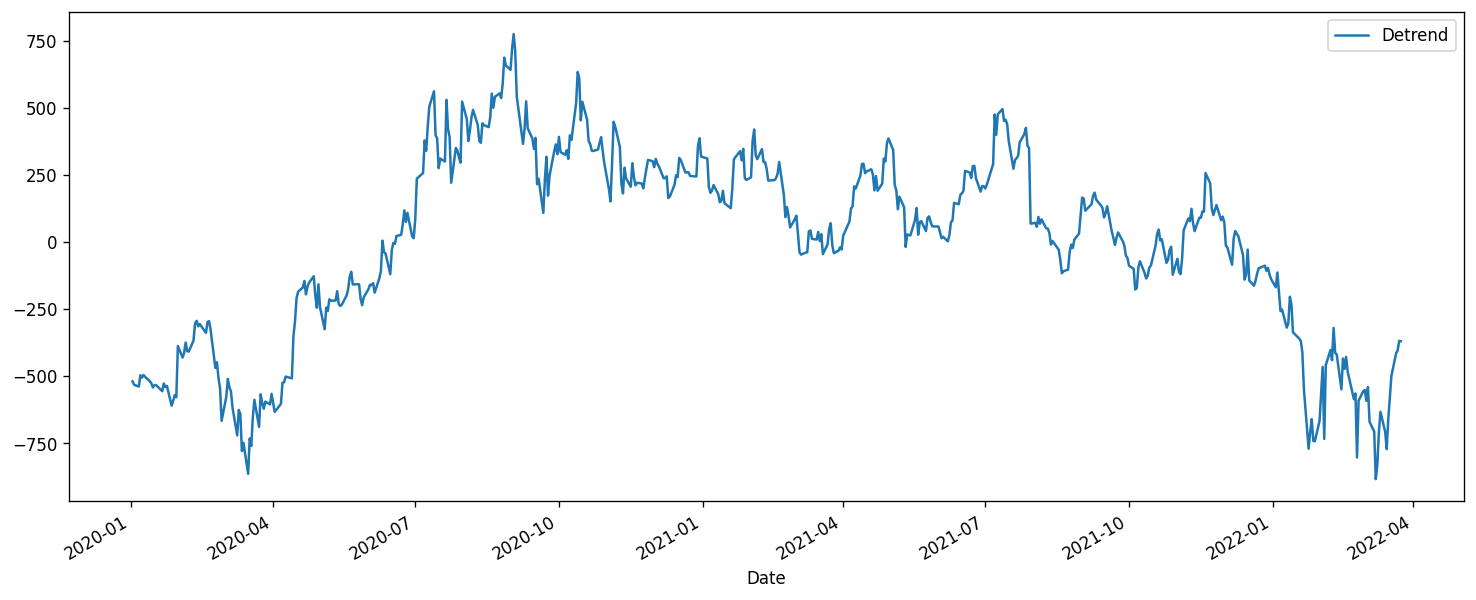

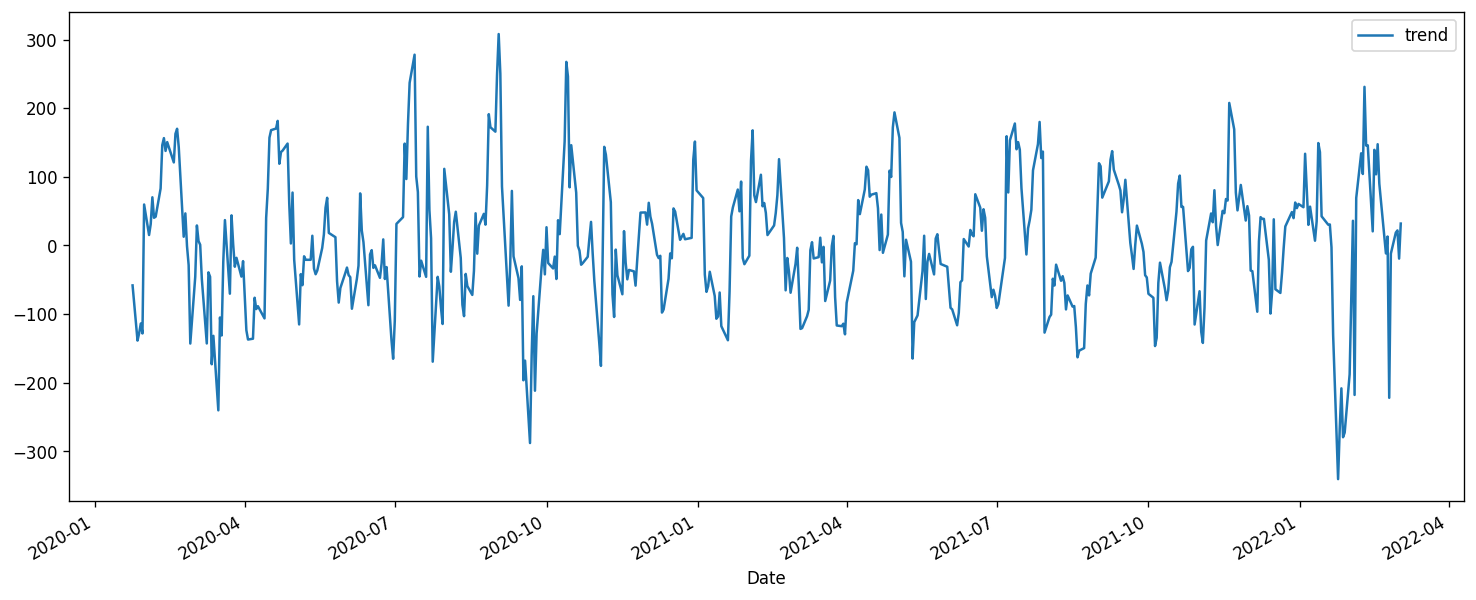

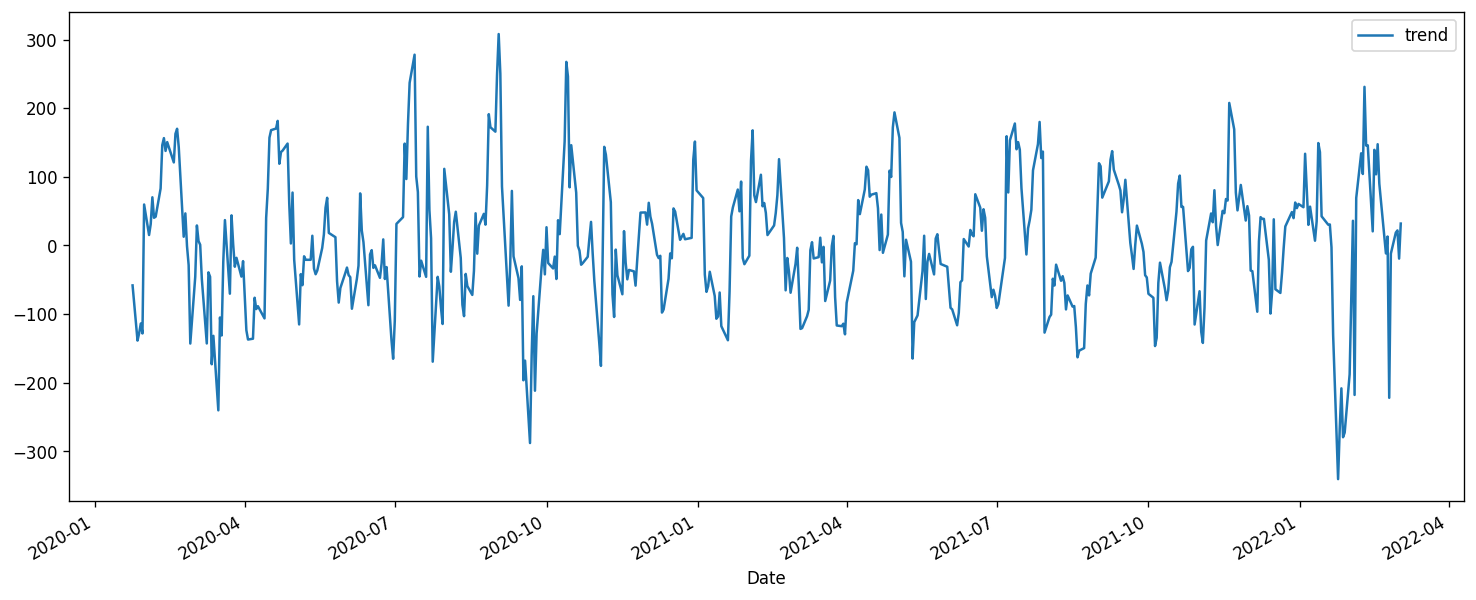

In [ ]:
#Senza trend
from scipy import signal
detrended = signal.detrend(df['Open'].values)
df['Detrend'] = pd.Series(detrended, df.index)
pd.DataFrame(df.Detrend).plot()


result_add = seasonal_decompose(df['Open'], model='additive', period=30)
detrended = df['Open'].values - result_add.trend

pd.DataFrame(detrended).plot()

#result_mul = seasonal_decompose(df['Open'], model='multiplicative', period=5)
#detrended = df['Open'].values - result_mul.trend

pd.DataFrame(detrended).plot()

ADF statistic serie originale (open) : -2.343251781769369
p ADF test serie originale (open) : 0.15839746603715632

ADF statistic serie differenziata 1 volta (open) : -25.37082257463226
p ADF test serie differenziata 1 volta (open) : 0.0

ADF statistic serie differenziata 2 volte (open) : -11.74975785430884
p ADF test serie differenziata 2 volte (open) : 1.2170975927642442e-21


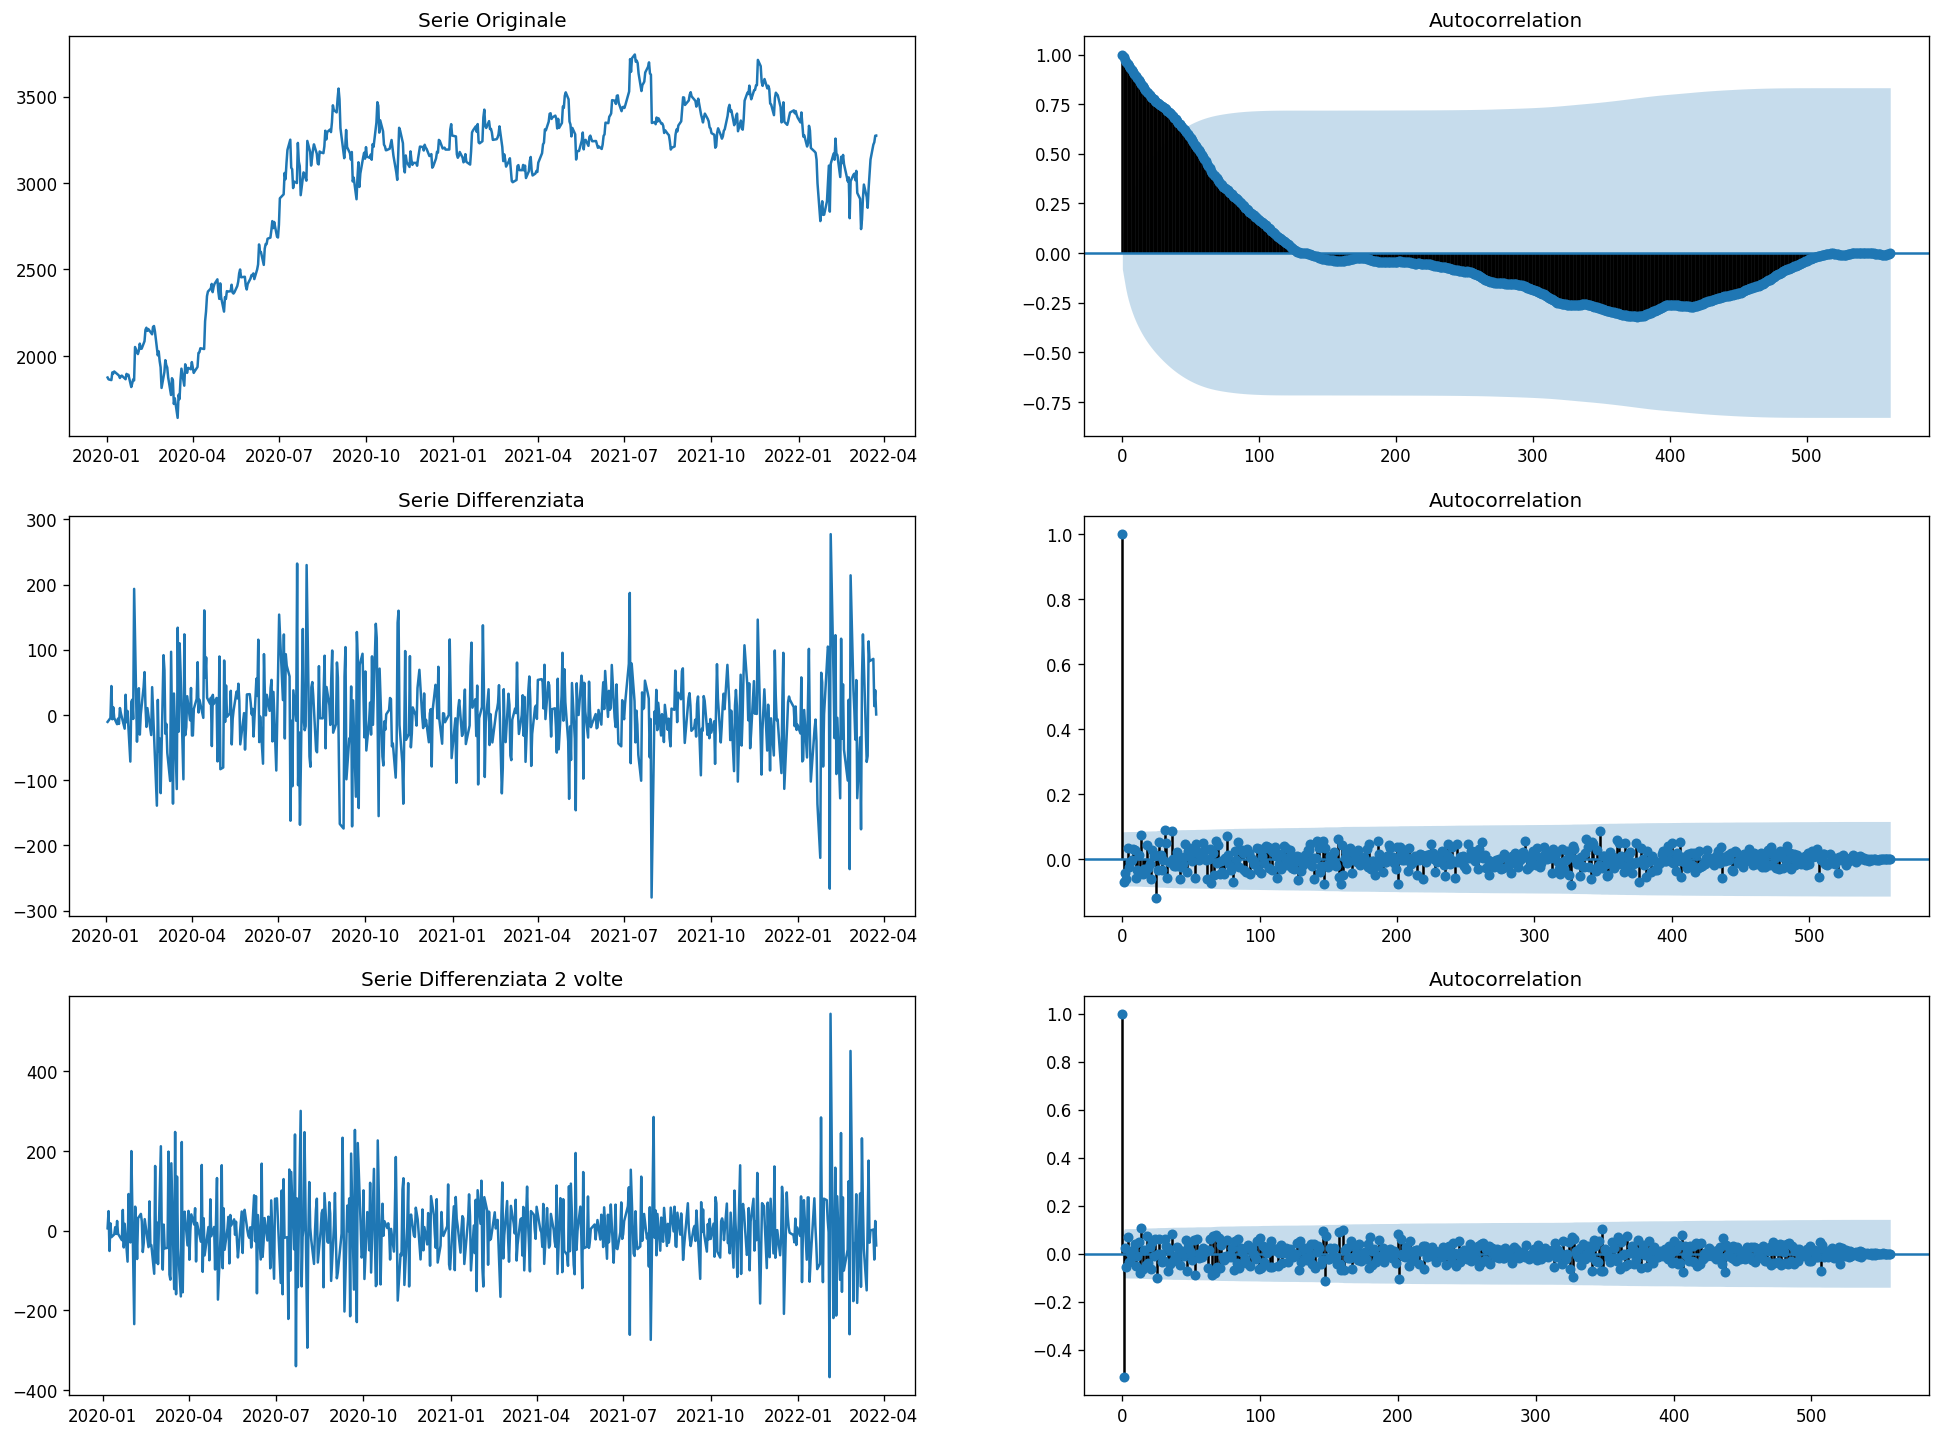

In [ ]:
#ADF test
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':120})

#Serie di letture di opening price
fig, axes = plt.subplots(nrows=3 , ncols=2, sharex=False)
axes[0,0].plot(df.Open)

axes[0,0].set_title("Serie Originale")
plot_acf(df.Open,ax=axes[0,1],lags=len(df.Open)-1)

result = adfuller(df.Open.dropna())
print("ADF statistic serie originale (open) : " + str(result[0]))
print("p ADF test serie originale (open) : " + str(result[1]))

#Differenziazione Primo ordine dell'attributo closing price
axes[1,0].plot(df.Open.diff())
axes[1,0].set_title("Serie Differenziata")
plot_acf(df.Open.diff().dropna(),ax=axes[1,1],lags=len(df.Open)-3)

result = adfuller(df.Open.diff().dropna())
print("\nADF statistic serie differenziata 1 volta (open) : " + str(result[0]))
print("p ADF test serie differenziata 1 volta (open) : " + str(result[1]))

#Differenziazione Secondo ordine dell'attributo closing price
axes[2,0].plot(df.Open.diff().diff())
axes[2,0].set_title("Serie Differenziata 2 volte")
plot_acf(df.Open.diff().diff().dropna(),ax=axes[2,1],lags=len(df.Open)-5)

result = adfuller(df.Open.diff().diff().dropna())
print("\nADF statistic serie differenziata 2 volte (open) : " + str(result[0]))
print("p ADF test serie differenziata 2 volte (open) : " + str(result[1]))

plt.show()

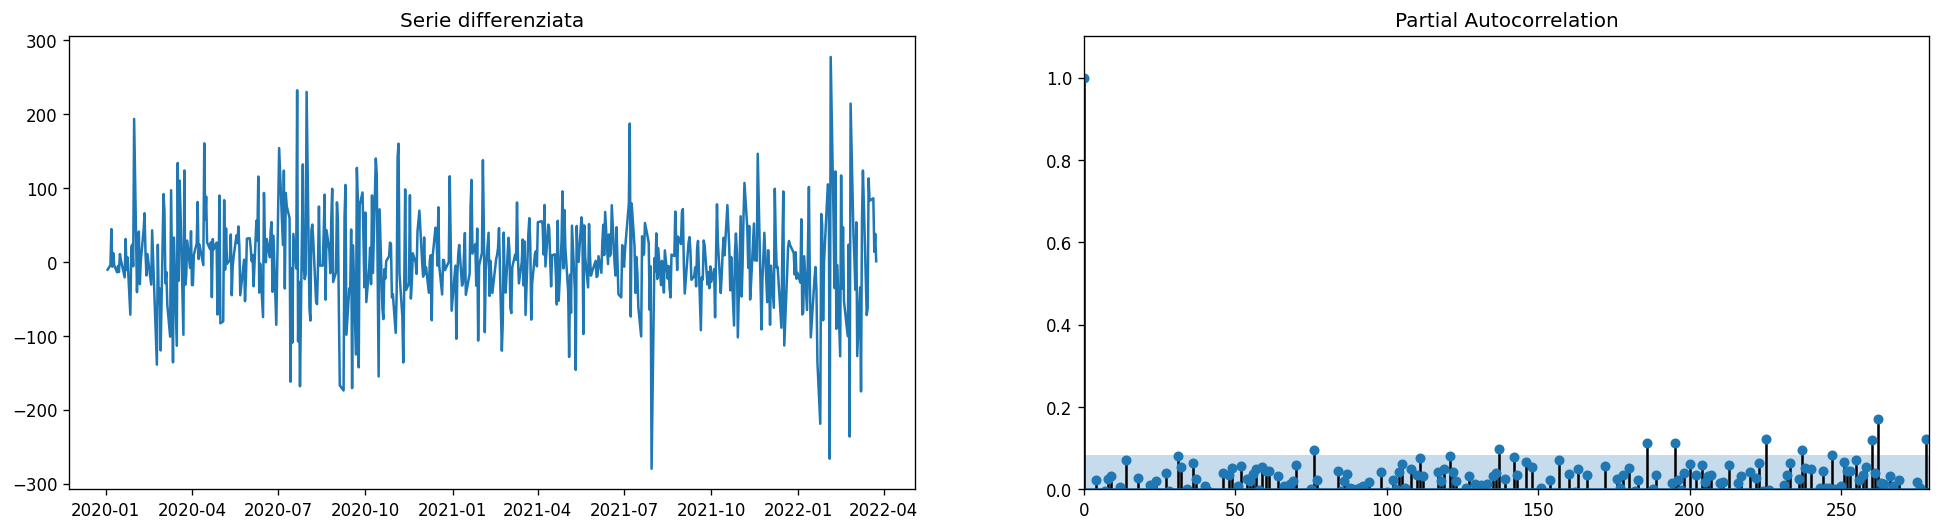

In [ ]:
#PACF della serie differenziata 1 volta (open)
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

fig, axes = plt.subplots(nrows=1 , ncols=2, sharex=False)
axes[0].plot(df.Open.diff())
axes[0].set_title("Serie differenziata")
axes[1].set(ylim=(0,1.1))
axes[1].set(xlim=(0,len(df.Open)/2 - 2))
plot_pacf(df.Open.diff().dropna(),ax=axes[1],lags=len(df.Open)/2 - 2)

plt.show()

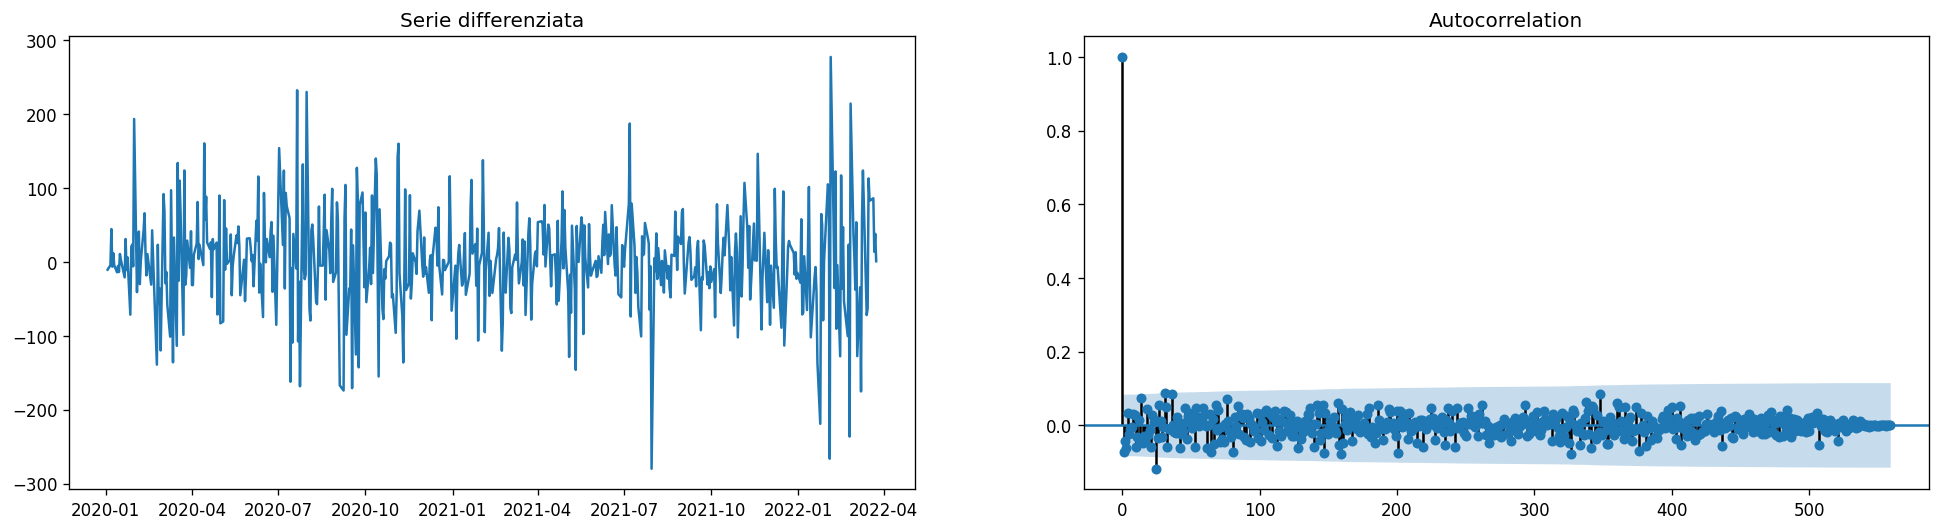

In [ ]:
#ACF della serie differenziata 1 volta (open)
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

fig, axes = plt.subplots(nrows=1 , ncols=2, sharex=False)
axes[0].plot(df.Open.diff())
axes[0].set_title("Serie differenziata")

plot_acf(df.Open.diff().dropna(),ax=axes[1],lags=len(df.Open)-3)

plt.show()

In [ ]:
#ARIMA model
warnings.filterwarnings("ignore")
model = ARIMA(df.Open, order=(1,1,1))
fitted = model.fit(disp=0)

print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                  561
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3143.404
Method:                       css-mle   S.D. of innovations             65.645
Date:                Tue, 06 Dec 2022   AIC                           6294.808
Time:                        10:28:45   BIC                           6312.127
Sample:                             1   HQIC                          6301.570
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4650      2.223      1.109      0.267      -1.892       6.822
ar.L1.D.Open     0.5978      0.301      1.986      0.047       0.008       1.188
ma.L1.D.Open    -0.6779      0.277     -2.44

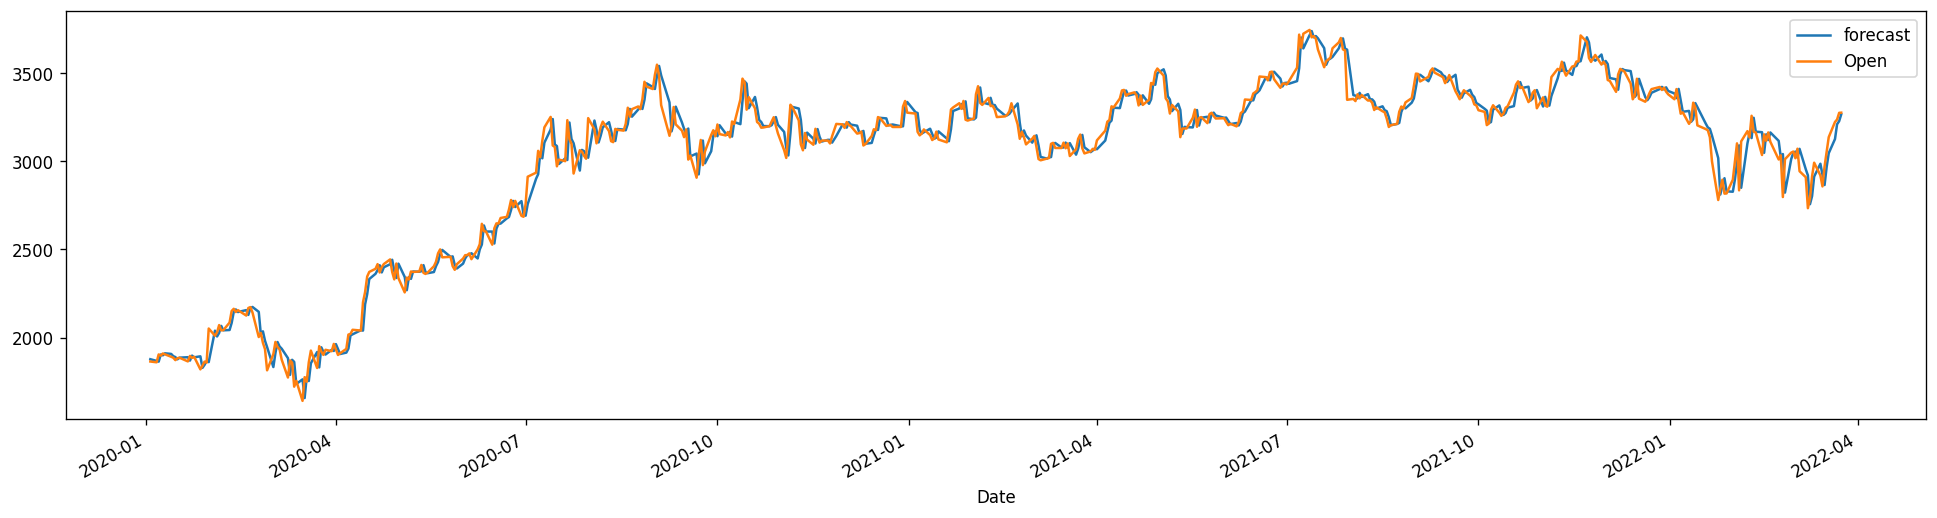

In [ ]:
#Previsione
fitted.plot_predict(dynamic=False)

plt.show()

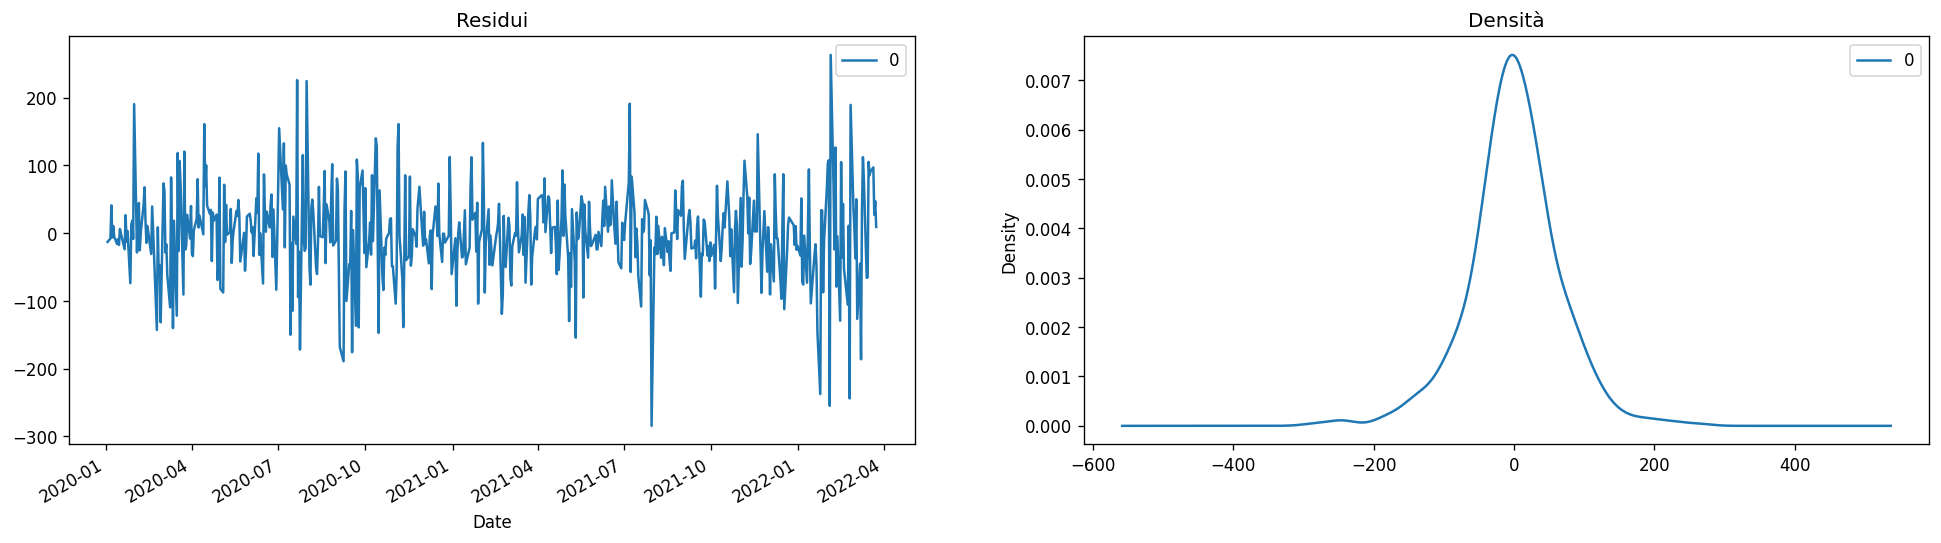

In [ ]:
residuals = pd.DataFrame(fitted.resid)

fig, axes = plt.subplots(nrows=1 , ncols=2, sharex=False)
#axes[0].set(xlim=(0,len(df.Open)))
#axes[1].set(xlim=(-len(df.Open),len(df.Open)))
residuals.plot(title="Residui",ax=axes[0])
residuals.plot(kind="kde",title="Densità",ax=axes[1])

plt.show()

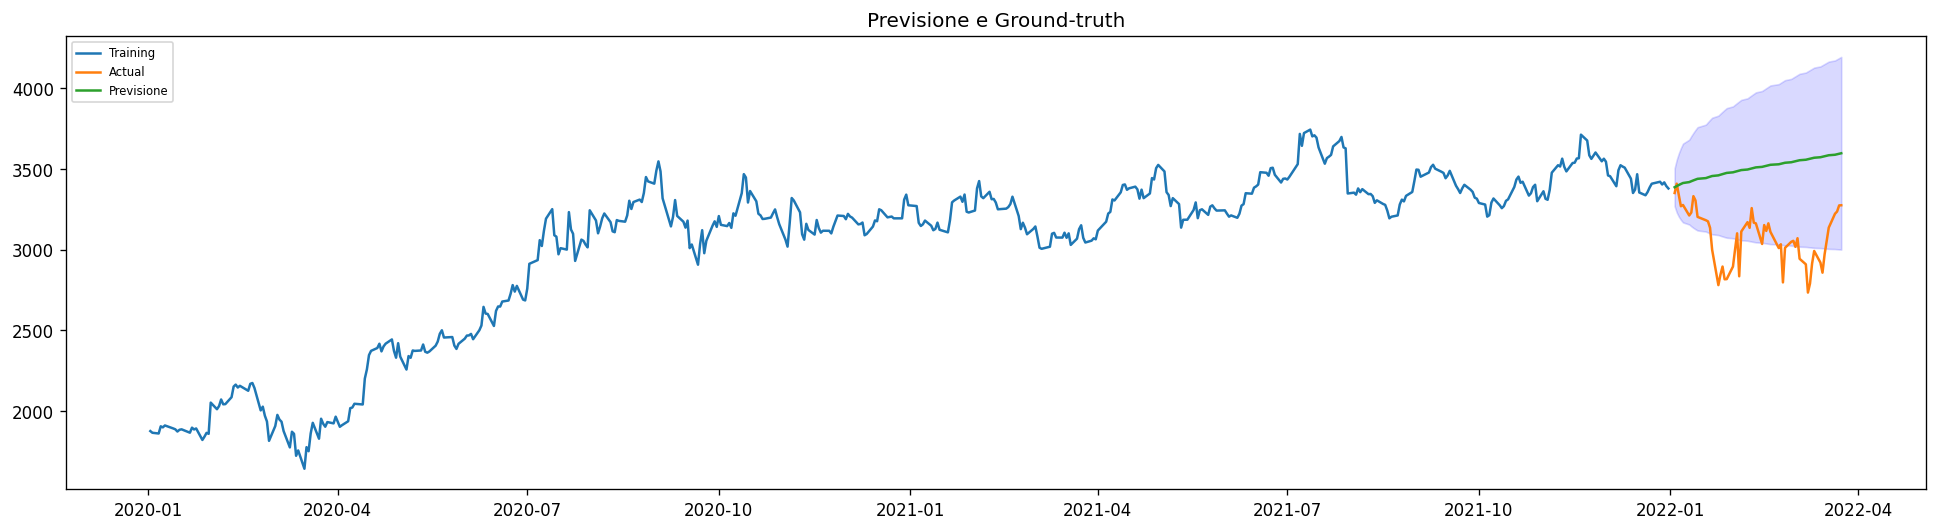

In [ ]:
#Cross-validation
train = df.Open[:505] #85%
test = df.Open[505:]  #15%

#Nuovo modello
model = ARIMA(train, order=(1,1,1))
fitted = model.fit(disp=-1)

fc, se, conf = fitted.forecast(57, alpha=0.05)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

plt.plot(train, label="Training")
plt.plot(test, label="Actual")
plt.plot(fc_series, label="Previsione")
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.15)

plt.title("Previsione e Ground-truth")
plt.legend(loc="upper left", fontsize=7)
plt.show()

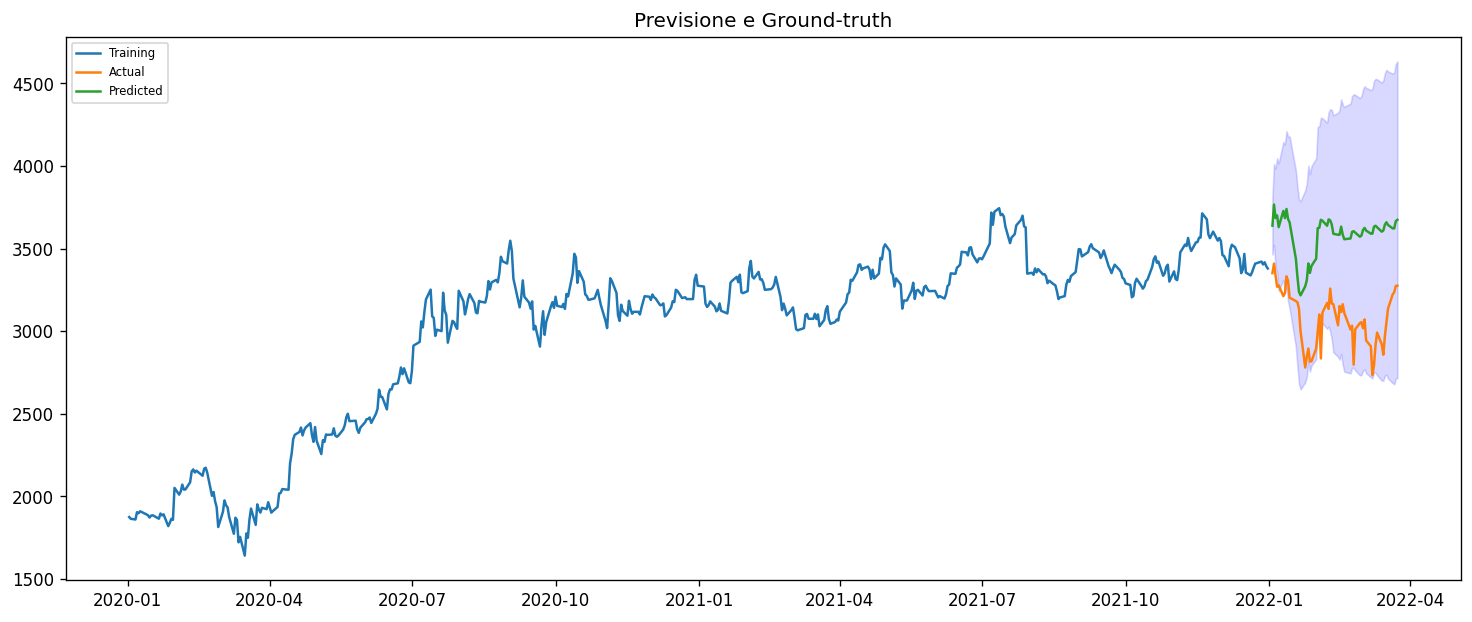

In [ ]:
#Cross-validation
train = df.Open[:505] #85%
test = df.Open[505:]  #15%

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':120})
plt.plot(train, label="Training")
plt.plot(test, label="Actual")

#Nuovo modello SARIMA
order = (1,1,1)
#seasonal_order = (1,3,5,5)
#seasonal_order = (0,3,7,5)
seasonal_order = (0,3,7,5)
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()

fc = sarima_fit.forecast(steps=57)
fc.index = test.index

forecast = sarima_fit.get_forecast(steps=57)
ci = forecast.conf_int()
ci.index=test.index

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(ci['lower Open'],index=test.index)
upper_series = pd.Series(ci['upper Open'],index=test.index)
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.15)
plt.plot(fc_series, label="Predicted")
plt.title("Previsione e Ground-truth")
plt.legend(loc="upper left", fontsize=7)

plt.show()

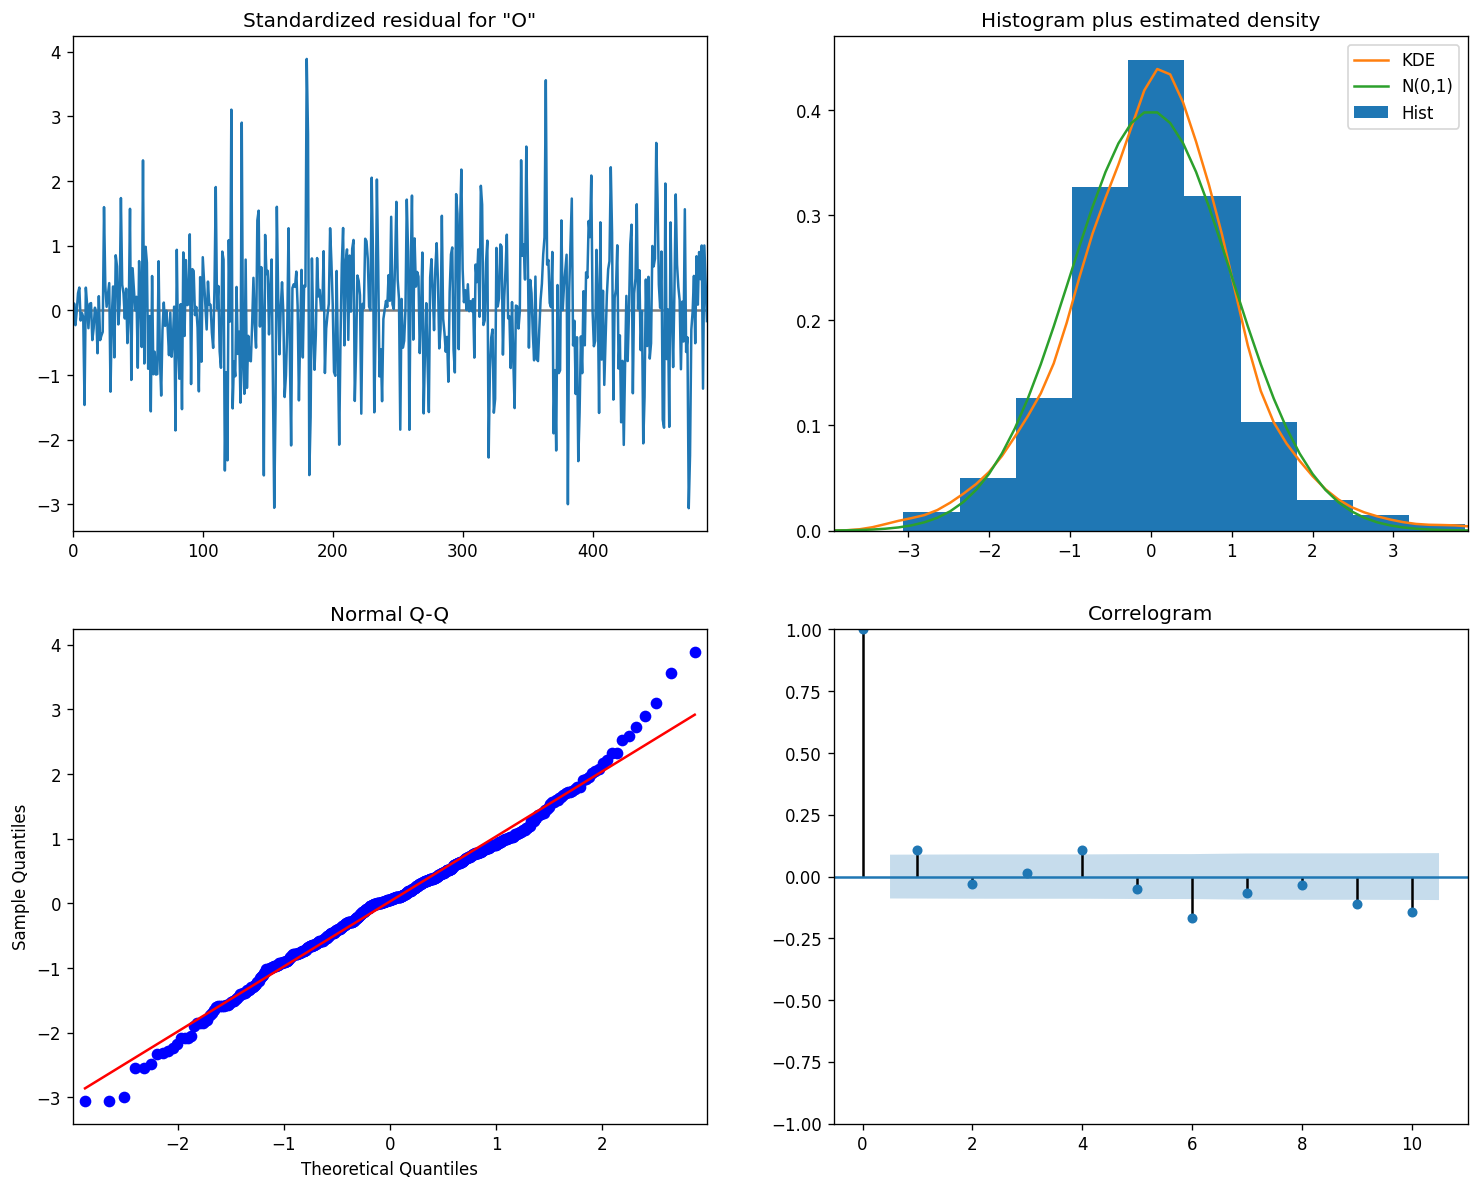

In [ ]:
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()



In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))  #MAPE
    me = np.mean(forecast-actual)                           #ME
    mae = np.mean(np.abs(forecast-actual))                  #MAE
    mpe = np.mean((forecast-actual)/actual)                 #MPE
    rmse = np.mean((forecast-actual)**2)**.5                #RMSE
    corr = np.corrcoef(forecast,actual)[0,1]                #corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                         #minmax
    acf1 = acf(forecast - actual)[1]

    return({'mape':mape, 'me':me, 'mae':mae, 'mpe':mpe,
            'rmse':rmse, 'corr':corr, 'acf1':acf1, 'minmax':minmax})
    
forecast_accuracy(fc_series,test)

{'mape': 0.16788869219540933,
 'me': 508.3705594456423,
 'mae': 508.3705594456423,
 'mpe': 0.16788869219540933,
 'rmse': 532.2024485574955,
 'corr': 0.45098910329983416,
 'acf1': 0.7248844300916056,
 'minmax': 0.14155438300875933}

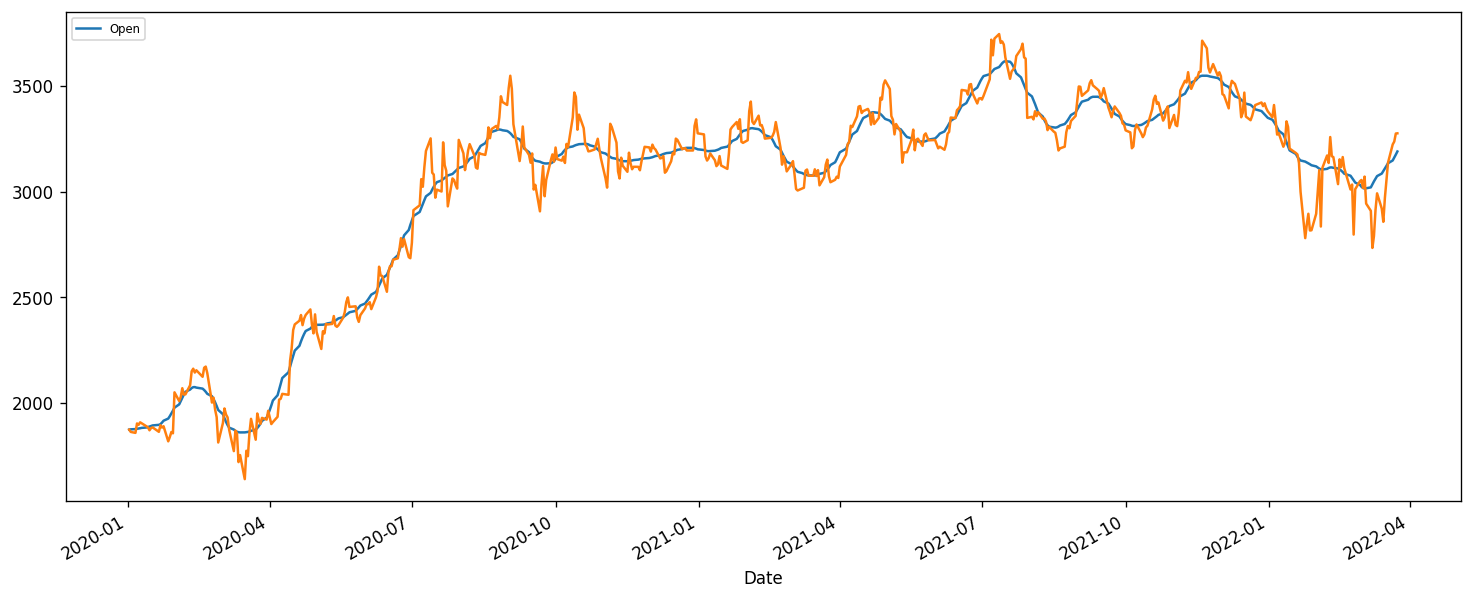

In [ ]:
#LOWESS
from statsmodels.nonparametric.smoothers_lowess import lowess as ls
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':120})
df = pd.read_csv('./AMZN_reduced.csv')
df = df[['Date','Open']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
lowess = ls
z = lowess(df.Open,np.arange(0,len(df.Open),1),frac=1./20)
w = np.reshape(z[:,1],len(z[:,1]))

SerieSmooth = pd.DataFrame(columns=["Date","Open"])
SerieSmooth["Date"] = df.Date
SerieSmooth["Open"] = w
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
SerieSmooth.set_index('Date', inplace=True)
SerieSmooth.index = pd.to_datetime(df.index, format="%Y-%m-%d")
SerieSmooth.plot()
plt.plot(df)

plt.show()

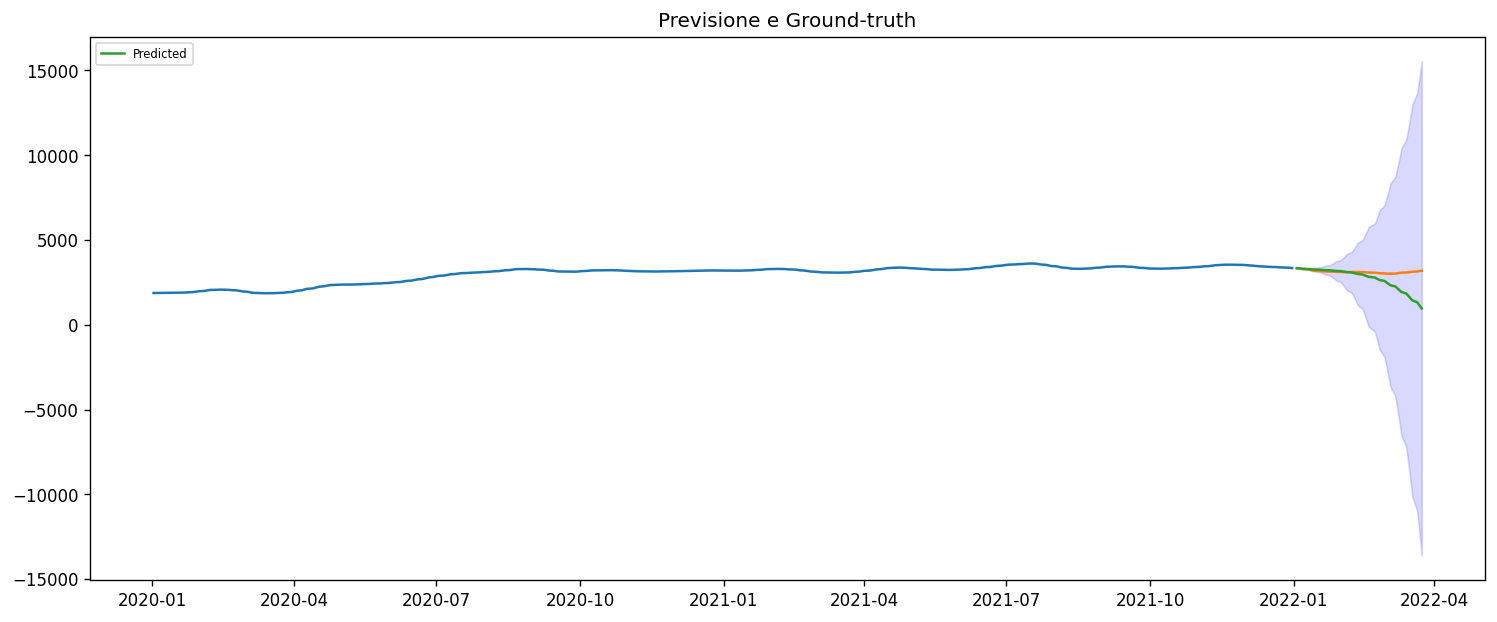

In [ ]:
'''
openStationary = df.Open.diff().dropna()

fig,axes = plt.subplots(2,2) #Set a subset for the data visualizations

a = axes[0,0].plot(df["Open"]) #Plot the original data
a = axes[0,0].set_title("Original Data") #Give the original data a name
b = plot_acf(df["Open"],ax=axes[0,1]) #Plot the ACF of the original data

x = axes[1,0].plot(openStationary) #Plot the stationary data
x = axes[1,0].set_title("Stationary Data") #Give the stationary data a name
y = plot_acf(openStationary,ax=axes[1,1]) #Plot the ACF of the stationary data

fig,axes = plt.subplots(1,2) #Create a subplot for the ACF

a = axes[0].plot(openStationary)#Plot the stationary data
a = axes[0].set_title("Stationary") #Ensure the stationary data is named
b = plot_acf(openStationary, ax = axes[1]) #Plot the ACF


a = axes[0].plot(openStationary)#Plot the stationary data
a = axes[0].set_title("Stationary") #Ensure the stationary data is named
b = plot_acf(openStationary, ax = axes[1]) #Plot the ACF
'''

"""
train = SerieSmooth.Open[:477]  #85%
test = SerieSmooth.Open[477:]   #15%
"""
train = SerieSmooth.Open[:505]  #90%
test = SerieSmooth.Open[505:]   #10%

plt.plot(train)
plt.plot(test)

order = (1,1,1)
#seasonal_order = (1,3,5,15)
#seasonal_order = (2,0,10,5)
seasonal_order = (1,3,4,5)
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.forecast(steps=57)
sarima_pred.index = test.index

forecast = sarima_fit.get_forecast(steps=57)
ci = forecast.conf_int()
ci.index=test.index

fc_series = pd.Series(sarima_pred, index=test.index)
lower_series = pd.Series(ci['lower Open'],index=test.index)
upper_series = pd.Series(ci['upper Open'],index=test.index)
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.15)
plt.plot(fc_series, label="Predicted")
plt.title("Previsione e Ground-truth")
plt.legend(loc="upper left", fontsize=7)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))  #MAPE
    me = np.mean(forecast-actual)                           #ME
    mae = np.mean(np.abs(forecast-actual))                  #MAE
    mpe = np.mean((forecast-actual)/actual)                 #MPE
    rmse = np.mean((forecast-actual)**2)**.5                #RMSE
    corr = np.corrcoef(forecast,actual)[0,1]                #corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                         #minmax
    acf1 = acf(forecast - actual)[1]

    return({'mape':mape, 'me':me, 'mae':mae, 'mpe':mpe,
            'rmse':rmse, 'corr':corr, 'acf1':acf1, 'minmax':minmax})
    
forecast_accuracy(fc_series,test)

{'mape': 0.15053972005300265,
 'me': -431.3977261496768,
 'mae': 467.5485559747921,
 'mpe': -0.13910900841861387,
 'rmse': 774.3467589716756,
 'corr': 0.3477466504084245,
 'acf1': 0.9231160123279302,
 'minmax': 0.15043508362035107}